<a href="https://colab.research.google.com/github/suhyunesther/Deep-Learning/blob/main/fruits_type_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Fruits Type prediction**
Personal project : 김수현

## 0. setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8672/8672), done.
remote: Total 385858 (delta 36), reused 8670 (delta 21), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 13.88 MiB/s, done.
Resolving deltas: 100% (1196/1196), done.
Checking out files: 100% (90503/90503), done.


numpy array 으로 data 를 loading 합니다.


In [ ]:
from sklearn.datasets import load_files
import numpy as np

train_dir = '/content/Fruit-Images-Dataset/Training/'
test_dir = '/content/Fruit-Images-Dataset/Test/'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  67692
Testing set size :  22688


131 종류의 과일이 있습니다.

In [ ]:
no_of_classes = len(np.unique(y_train))
no_of_classes

131

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

validation set 을 test, validation 으로 나눕니다.


In [ ]:
x_test,x_valid = x_test[7000:],x_test[:7000]
y_test,y_vaild = y_test[7000:],y_test[:7000]
print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_vaild.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)

Vaildation X :  (7000,)
Vaildation y : (7000, 131)
Test X :  (15688,)
Test y :  (15688, 131)


이미지 파일 이름인 training data 를 pixel matrix 로 전환하고 이미지와 array 로 확인 합니다. 


In [ ]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (67692, 100, 100, 3)
Validation set shape :  (7000, 100, 100, 3)
Test set shape :  (15688, 100, 100, 3)
1st training image shape  (100, 100, 3)


In [ ]:
print('1st training image as array',x_train[0]) # don't worry if you see only 255s..
# there are elements will other values too :p

In [ ]:
# time to re-scale so that all the pixel values lie within 0 to 1
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train[0]

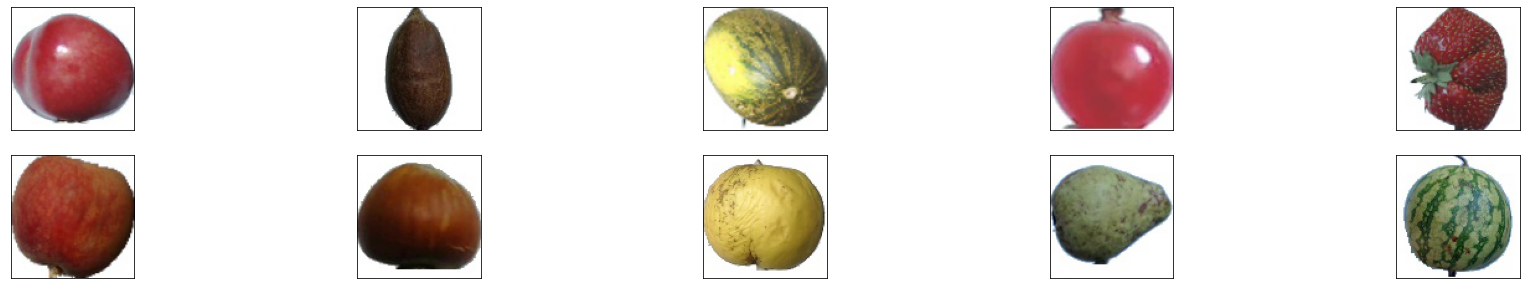

In [ ]:
#Let's visualize the first 10 training images!
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
# Yummy fruits ;)

## 1. 1st model

### construct the model

Conv layer 를 maxpooling 과 함께 3 층 넣었고 dropout 과 flatten, dence layer 를 추가한 모델을 만들었습니다.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(131,activation = 'softmax'))
#model.add(Dense(81,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

loss 와 optimizer, metrics 설정으로 모델 컴파일을 했습니다.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


### train & predict the model




batch size 를 32, epoch 을 30 으로 학습시켰습니다.

In [ ]:
checkpointer = ModelCheckpoint(filepath = '/content/Fruit-Images-Dataset/results1.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=30,
        validation_data=(x_valid, y_vaild),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Epoch 1/30
2116/2116 - 42s - loss: 1.0326 - accuracy: 0.7135 - val_loss: 0.5484 - val_accuracy: 0.8779

Epoch 00001: val_loss improved from inf to 0.54835, saving model to /content/Fruit-Images-Dataset/results1.hdf5
Epoch 2/30
2116/2116 - 12s - loss: 0.1595 - accuracy: 0.9476 - val_loss: 0.2186 - val_accuracy: 0.9564

Epoch 00002: val_loss improved from 0.54835 to 0.21863, saving model to /content/Fruit-Images-Dataset/results1.hdf5
Epoch 3/30
2116/2116 - 12s - loss: 0.0952 - accuracy: 0.9694 - val_loss: 0.2337 - val_accuracy: 0.9560

Epoch 00003: val_loss did not improve from 0.21863
Epoch 4/30
2116/2116 - 12s - loss: 0.0777 - accuracy: 0.9764 - val_loss: 0.2415 - val_accuracy: 0.9547

Epoch 00004: val_loss did not improve from 0.21863
Epoch 5/30
2116/2116 - 12s - loss: 0.0723 - accuracy: 0.9795 - val_loss: 0.2249 - val_accuracy: 0.9710

Epoch 00005: val_loss did not improve from 0.21863
Epoch 6/30
2116/2116 - 12s - loss: 0.0670 - accuracy: 0.9817 - val_loss: 0.2464 - val_accuracy: 0.9

In [ ]:
model.load_weights('/content/Fruit-Images-Dataset/results1.hdf5')

test accuracy 0.957 결과를 얻었습니다.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9567185044288635


### visualization the results

결과를 이미지화해서 확인했습니다.

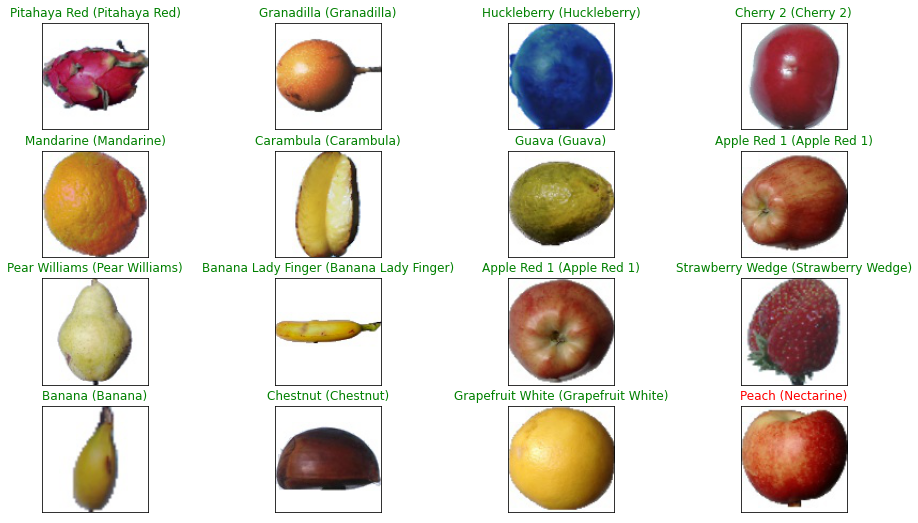

In [ ]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

epochs 에 따른 loss, accuracy 그래프를 확인했습니다. 전체적으로 성능이 괜찮으며 과적합이 의심되었습니다.

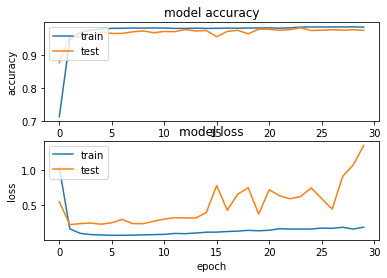

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  
      
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
      
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


## 2. 2nd model

CNN layer 구조를 조금 바꿔보고 성능을 높이고자 했습니다. \
처음 두 단계에서 Pooling 을 Max pooling 에서 Average pooling 으로 바꾸고 pooling size 는 전체 layer 에 3으로 증가 시켜 동일하게 학습시켰습니다.

In [ ]:
from keras.layers import AveragePooling2D

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(100,100,3),padding='same'))
model.add(Activation('relu')) #'elu #softplus
model.add(AveragePooling2D(pool_size=3))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(AveragePooling2D(pool_size=3))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=3))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(131,activation = 'softmax'))
#model.add(Dense(81,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 33, 33, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 32)        2080      
_________________________________________________________________
average_pooling2d_1 (Average (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 64)          0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [ ]:
checkpointer = ModelCheckpoint(filepath = '/content/Fruit-Images-Dataset/results2.hdf5', verbose = 1, save_best_only = True)

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=30,
        validation_data=(x_valid, y_vaild),
        callbacks = [checkpointer],
        verbose=1, shuffle=True)

Epoch 1/30
2116/2116 [==============================] - 41s 7ms/step - loss: 3.0305 - accuracy: 0.2503 - val_loss: 0.5905 - val_accuracy: 0.8370

Epoch 00001: val_loss improved from inf to 0.59054, saving model to /content/Fruit-Images-Dataset/results2.hdf5
Epoch 2/30
2116/2116 [==============================] - 13s 6ms/step - loss: 0.6666 - accuracy: 0.7777 - val_loss: 0.3387 - val_accuracy: 0.8990

Epoch 00002: val_loss improved from 0.59054 to 0.33875, saving model to /content/Fruit-Images-Dataset/results2.hdf5
Epoch 3/30
2116/2116 [==============================] - 13s 6ms/step - loss: 0.3812 - accuracy: 0.8701 - val_loss: 0.2914 - val_accuracy: 0.9113

Epoch 00003: val_loss improved from 0.33875 to 0.29144, saving model to /content/Fruit-Images-Dataset/results2.hdf5
Epoch 4/30
2116/2116 [==============================] - 13s 6ms/step - loss: 0.2820 - accuracy: 0.9069 - val_loss: 0.3481 - val_accuracy: 0.9094

Epoch 00004: val_loss did not improve from 0.29144
Epoch 5/30
2116/2116 

In [ ]:
model.load_weights('/content/Fruit-Images-Dataset/results2.hdf5')

test accuracy 가 0.977 으로 조금 증가했습니다.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9774349927902222


또한 overfitting 도 줄어든 결과를 낼 수 있었습니다.

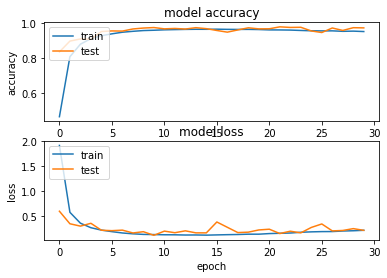

In [ ]:
y_pred = model.predict(x_test)

import matplotlib.pyplot as plt 
plt.figure(1)  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()